Based on the MetPy example ["Station Plot with Layout"](http://metpy.readthedocs.org/en/latest/examples/generated/Station_Plot_with_Layout.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from awips.dataaccess import DataAccessLayer

from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot, StationPlotLayout, simple_layout
from metpy.units import units

%matplotlib inline
from IPython.display import display, HTML

pp = pprint.PrettyPrinter(depth=1)

In [2]:
# Initialize
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

request = DataAccessLayer.newDataRequest()
request.setDatatype("obs")

In [3]:
param_list = np.array(["time", "stationName", "longitude", "latitude", "temperature", "dewpoint", 
                       "windDir","windSpeed", "seaLevelPress", "presWeather",
                       "skyCover", "skyLayerBase"])

we need to set one station to query latest time.  this is hack-y and should be fixed
because when you DON'T set a location name, you tend to get a single observation
that came in a second ago, so your "latest data for the last time for all stations"
data array consists of one village in Peru and time-matching is suspect right now.

So here take a known US station (OKC) and hope/assume that a lot of other stations 
are also reporting (and that this is a 00/20/40 ob). 

In [4]:
request.setLocationNames("KOKC")
datatimes = DataAccessLayer.getAvailableTimes(request)

# Get most recent time for location
time = datatimes[-1].validPeriod

print time.start

2016-06-03 18:52:00


Build a dictionary for observations that have a stationName

In [5]:
# "presWeather","skyCover","skyLayerBase"
# are multi-dimensional(??) and returned seperately (not sure why yet)... deal with those later
# '*param_list' unpacks the parameter strings from the array.
# We ignore the first parameter (ie, [1:]) since it ("time") will not be returned by 
# the response object.
request.setParameters(*param_list[1:])
request.setLocationNames()

response = DataAccessLayer.getGeometryData(request, times=time)

obs_dict = dict({param_list: [] for param_list in param_list})

for ob in response:
    avail_params = ob.getParameters()

    if "stationName" in avail_params:
        
        for param in param_list:
            
            if param in avail_params:
                value = ob.getString(param)

                try:
                    obs_dict[param].append(float(value))

                except ValueError:
                    obs_dict[param].append(value)
                    
            elif param == "time":
                obs_dict['time'].append(time.start)
            
            #need to represent missing data to keep each list
            #in the dictionary the same length
            else:
                obs_dict[param].append(None)

pp.pprint(obs_dict)

{'dewpoint': [...],
 'latitude': [...],
 'longitude': [...],
 'presWeather': [...],
 'seaLevelPress': [...],
 'skyCover': [...],
 'skyLayerBase': [...],
 'stationName': [...],
 'temperature': [...],
 'time': [...],
 'windDir': [...],
 'windSpeed': [...]}


Convert dict to something metpy-readable by 
attaching units and calculating derived values

In [6]:
data = dict()
data['latitude']  = np.array(obs_dict['latitude'])
data['longitude'] = np.array(obs_dict['longitude'])
data['air_temperature'] = np.array(obs_dict['temperature'])* units.degC
data['dew_point_temperature'] = np.array(obs_dict['dewpoint'])* units.degC
#data['air_pressure_at_sea_level'] = np.array(seaLevelPress)* units('mbar')
u, v = get_wind_components(np.array(obs_dict['windSpeed']) * units('knots'),
                           np.array(obs_dict['windDir']) * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

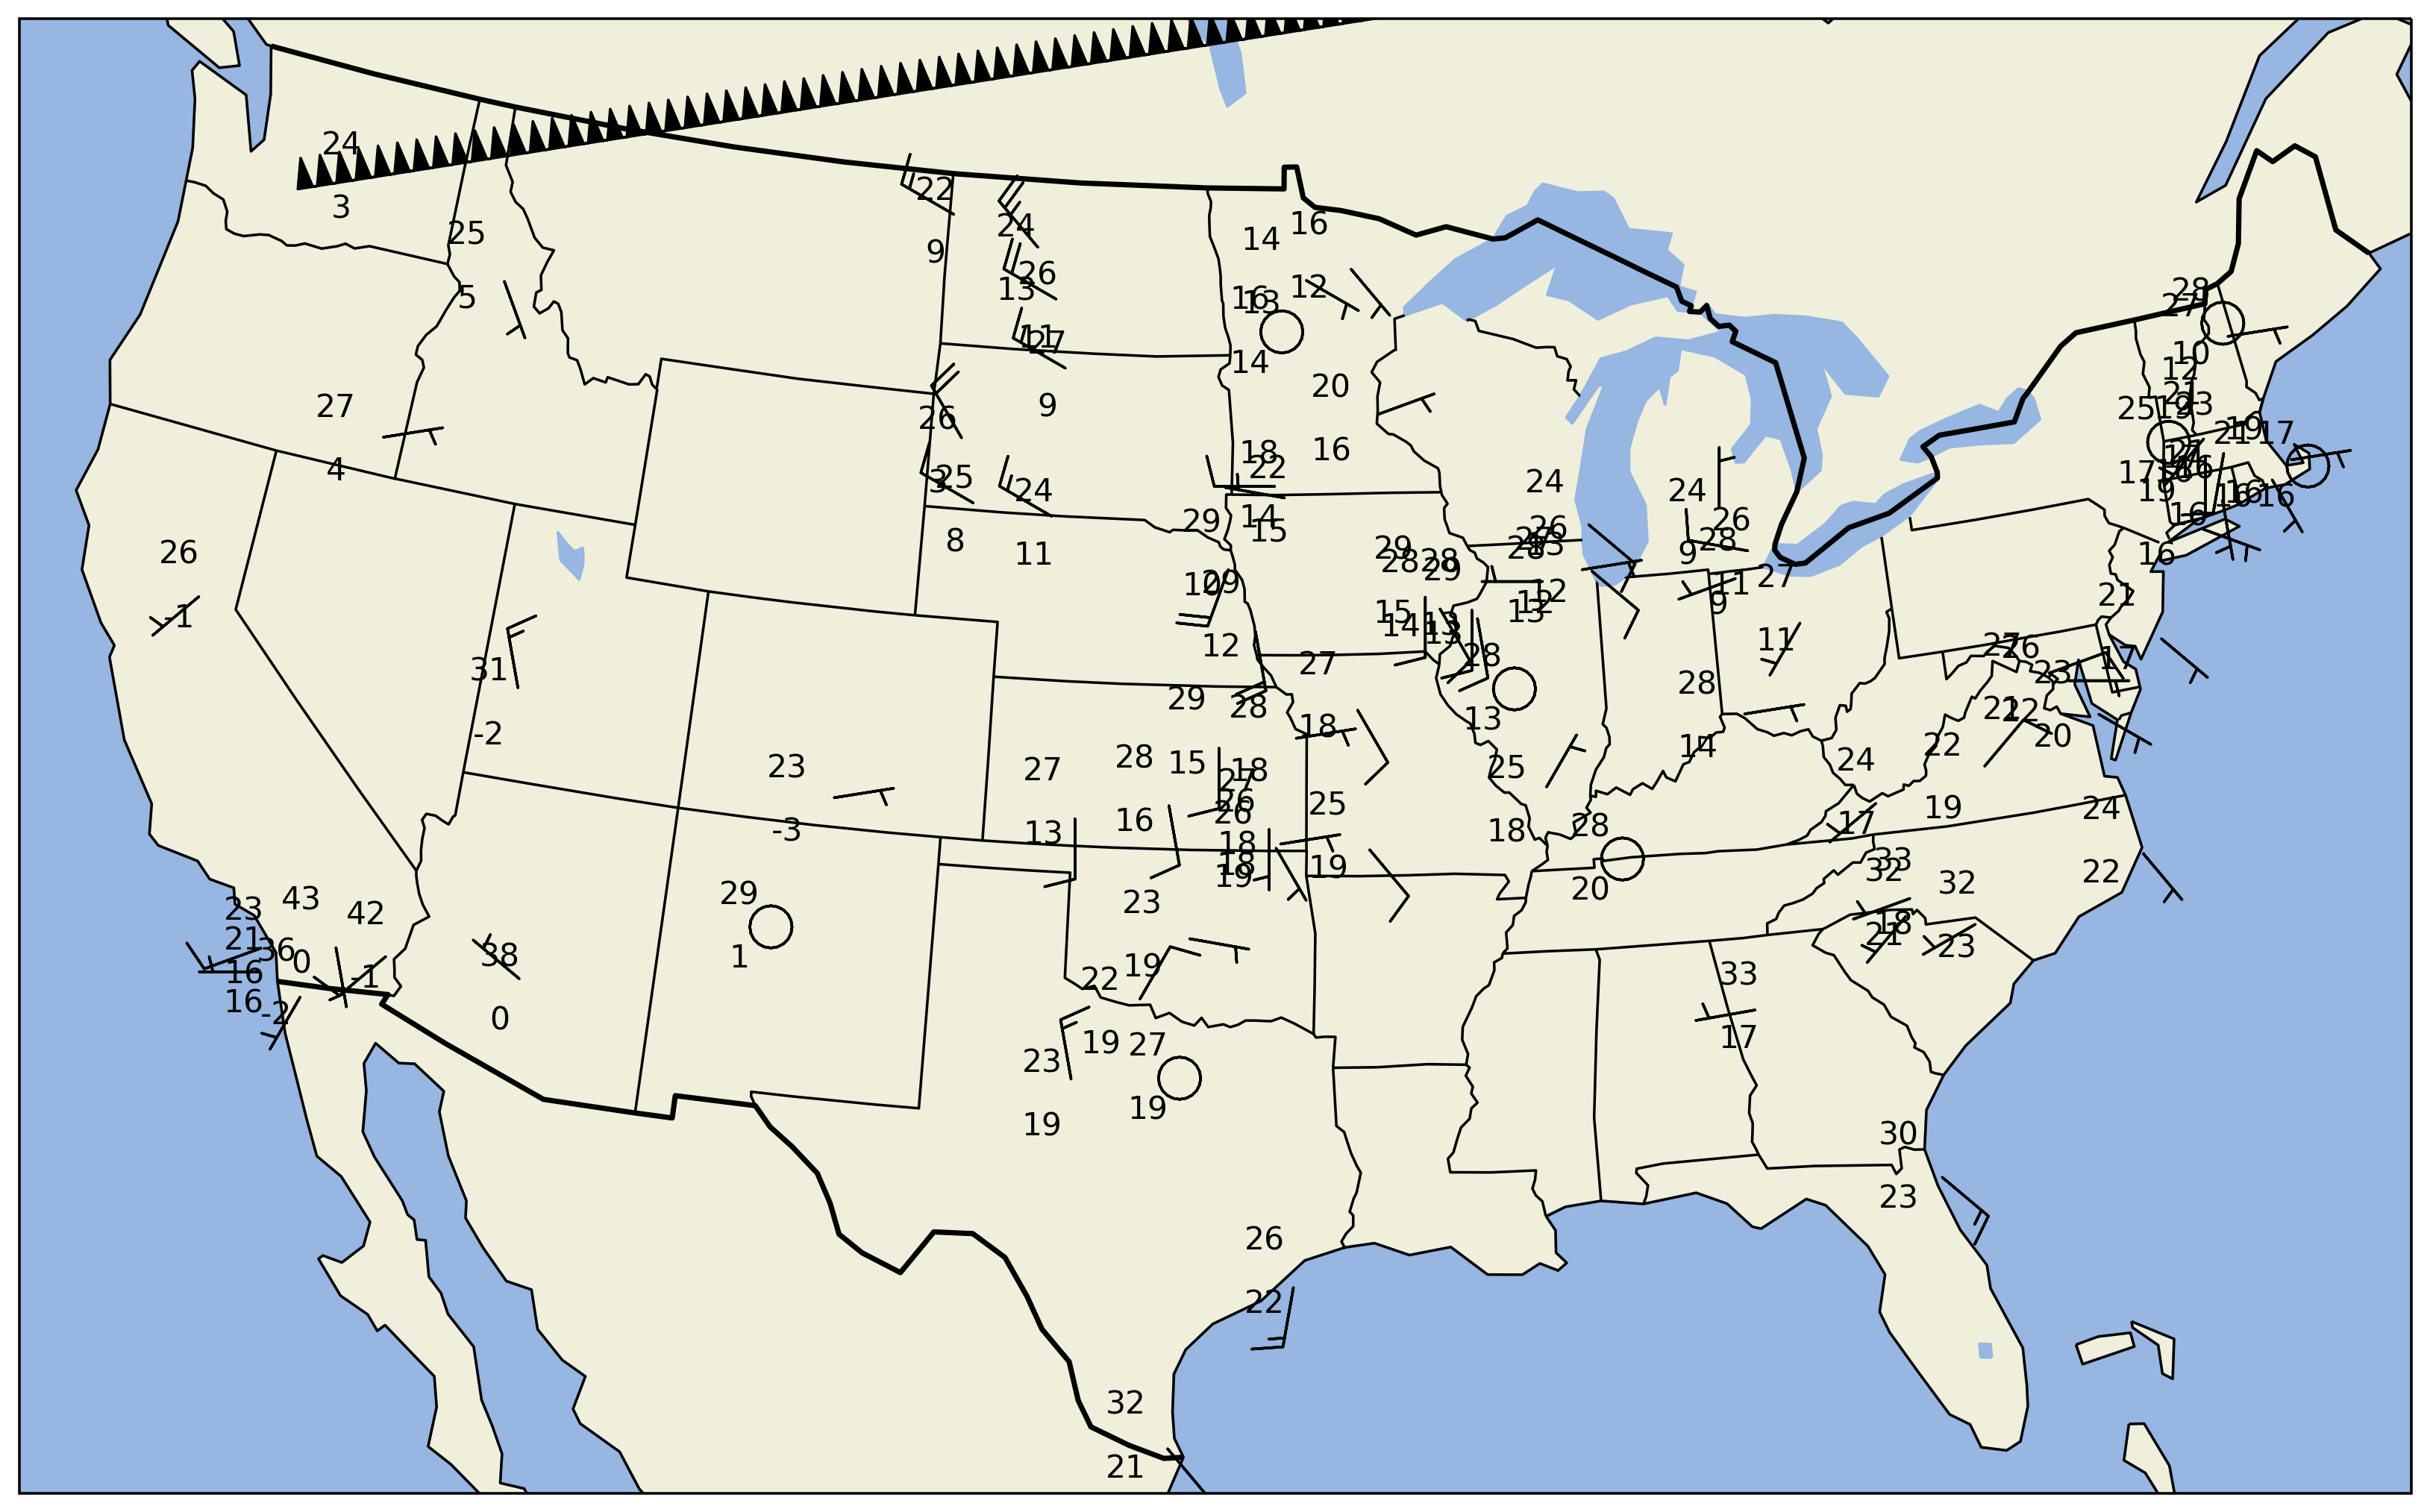

In [7]:
# Convert the fraction value into a code of 0-8, which can be used to pull out
# the appropriate symbol
#data['cloud_coverage'] = (8 * data_arr['cloud_fraction']).astype(int)

# Map weather strings to WMO codes, which we can use to convert to symbols
# Only use the first symbol if there are multiple
#wx_text = make_string_list(data_arr['weather'])
#wx_codes = {'':0, 'HZ':5, 'BR':10, '-DZ':51, 'DZ':53, '+DZ':55,
#            '-RA':61, 'RA':63, '+RA':65, '-SN':71, 'SN':73, '+SN':75}
#data['present_weather'] = [wx_codes[s.split()[0] if ' ' in s else s] for s in wx]

# Set up the map projection
import cartopy.crs as ccrs
import cartopy.feature as feat
from matplotlib import rcParams
rcParams['savefig.dpi'] = 255
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='110m', facecolor='none')
# Create the figure
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add map elements 
ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')
ax.set_extent((-120, -73, 23, 50))

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
simple_layout.plot(stationplot, data)

Something weird is happening with the data for a plot in Washington.

We can use pandas to investigate.  This part requires the "pandas" library.

In this case, lets use all the data (not just those with station names).

Rebuild the data dictionary and use it to create a pandas DataFrame object.

In [8]:
import pandas as pd

obs_dict = dict({param_list: [] for param_list in param_list})

for ob in response:
    avail_params = ob.getParameters()
        
    for param in param_list:

        if param in avail_params:
            value = ob.getString(param)

            try:
                obs_dict[param].append(float(value))

            except ValueError:
                obs_dict[param].append(value)

        elif param == "time":
            obs_dict['time'].append(time.start)

        #need to represent missing data to keep each list
        #in the dictionary the same length
        else:
            obs_dict[param].append(None)
                
obs = pd.DataFrame(data=obs_dict, columns=param_list)

HTML(obs.to_html())

,time,stationName,longitude,latitude,temperature,dewpoint,windDir,windSpeed,seaLevelPress,presWeather,skyCover,skyLayerBase
0,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,None,NaN
1,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,None,NaN
2,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,None,NaN
3,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,None,NaN
4,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,None,NaN
5,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,FEW,100.0
6,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,BKN,500.0
7,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,OVC,1300.0
8,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,OVC,4000.0
9,2016-06-03 18:52:00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,,-9999.0


We can prune the data by removing rows where stationName is missing

In [9]:
obs = obs[obs.stationName.notnull()]

HTML(obs.to_html())

,time,stationName,longitude,latitude,temperature,dewpoint,windDir,windSpeed,seaLevelPress,presWeather,skyCover,skyLayerBase
11,2016-06-03 18:52:00,CYUA,-137.229996,68.940002,0.0,-9999.0,320.0,6.0,-9999.000000,None,None,NaN
23,2016-06-03 18:52:00,KREO,-117.889999,42.580002,27.0,4.0,-9999.0,5.0,1021.900024,None,None,NaN
35,2016-06-03 18:52:00,KCZZ,-116.470001,32.619999,36.0,-2.0,210.0,7.0,1013.400024,None,None,NaN
47,2016-06-03 18:52:00,KNZY,-117.214996,32.699001,21.0,16.0,270.0,6.0,1014.700012,None,None,NaN
59,2016-06-03 18:52:00,KNRB,-81.424004,30.392000,30.0,23.0,130.0,13.0,1017.000000,None,None,NaN
71,2016-06-03 18:52:00,KNFW,-97.400002,32.799999,27.0,19.0,0.0,0.0,1011.400024,None,None,NaN
83,2016-06-03 18:52:00,KP69,-115.599998,46.150002,25.0,5.0,160.0,5.0,1022.400024,None,None,NaN
95,2016-06-03 18:52:00,KCDJ,-93.580002,39.820000,27.0,18.0,150.0,8.0,1015.099976,None,None,NaN
107,2016-06-03 18:52:00,KN60,-101.400002,47.610001,24.0,13.0,320.0,23.0,1010.599976,None,None,NaN
119,2016-06-03 18:52:00,KMHK,-96.669998,39.160000,29.0,15.0,180.0,10.0,1013.799988,None,None,NaN


Lets see where the wind has a weird value by sorting the DataFrame.

In [10]:
obs.sort_values(by="windSpeed", inplace=True)

HTML(obs.to_html())

,time,stationName,longitude,latitude,temperature,dewpoint,windDir,windSpeed,seaLevelPress,presWeather,skyCover,skyLayerBase
191,2016-06-03 18:52:00,KMWH,-119.320000,47.209999,24.0,3.0,-9999.0,-9999.0,1023.799988,None,None,NaN
479,2016-06-03 18:52:00,KBML,-71.180000,44.590000,28.0,10.0,0.0,0.0,1013.900024,None,None,NaN
803,2016-06-03 18:52:00,KABQ,-106.620003,35.049999,29.0,1.0,0.0,0.0,1013.200012,None,None,NaN
299,2016-06-03 18:52:00,KSPI,-89.669998,39.860001,28.0,13.0,0.0,0.0,1017.500000,None,None,NaN
359,2016-06-03 18:52:00,KADC,-95.211998,46.446999,16.0,14.0,0.0,0.0,-9999.000000,None,None,NaN
491,2016-06-03 18:52:00,KCKV,-87.419998,36.619999,28.0,20.0,0.0,0.0,1016.099976,None,None,NaN
407,2016-06-03 18:52:00,KAQW,-73.169998,42.709999,25.0,17.0,0.0,0.0,1015.500000,None,None,NaN
515,2016-06-03 18:52:00,KCQX,-69.989998,41.700001,17.0,16.0,0.0,0.0,1018.299988,None,None,NaN
71,2016-06-03 18:52:00,KNFW,-97.400002,32.799999,27.0,19.0,0.0,0.0,1011.400024,None,None,NaN
167,2016-06-03 18:52:00,ETAD,6.700000,49.980000,16.0,15.0,-9999.0,2.0,-9999.000000,None,None,NaN


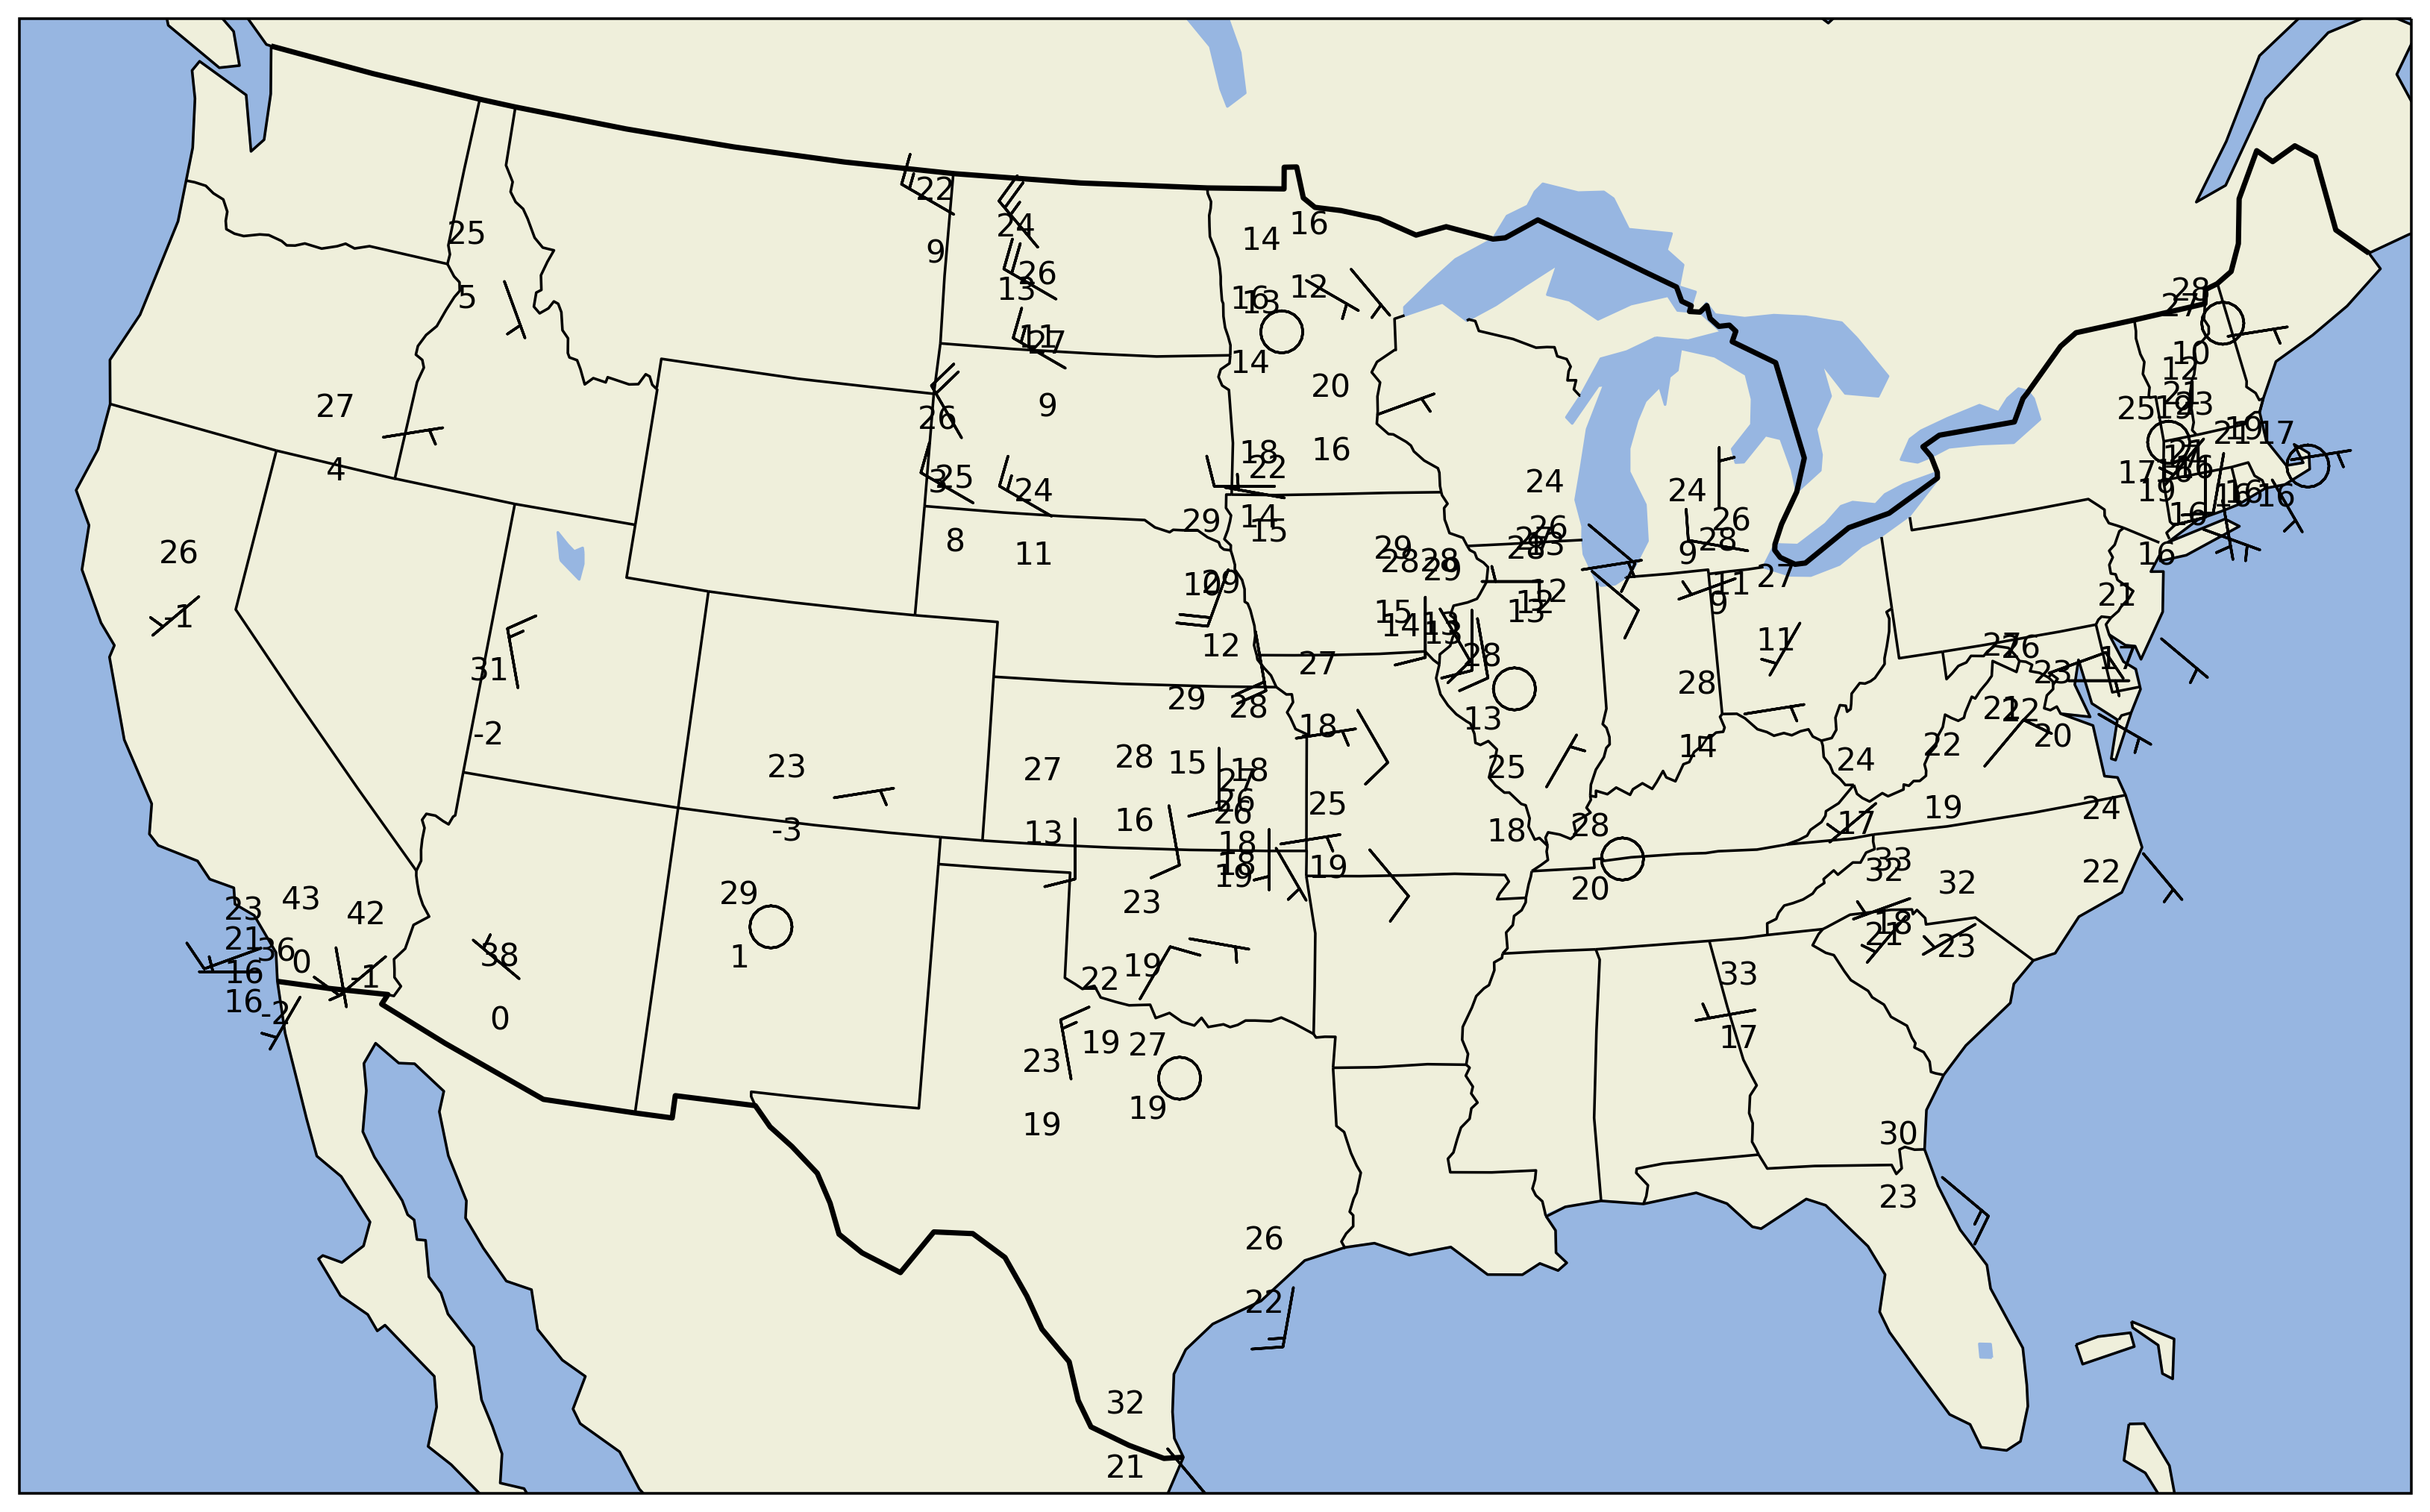

In [11]:
obs = obs[obs.windSpeed >= 0]

data = dict()
data['latitude']  = np.array(obs['latitude'])
data['longitude'] = np.array(obs['longitude'])
data['air_temperature'] = np.array(obs['temperature'])* units.degC
data['dew_point_temperature'] = np.array(obs['dewpoint'])* units.degC
#data['air_pressure_at_sea_level'] = np.array(seaLevelPress)* units('mbar')
u, v = get_wind_components(np.array(obs['windSpeed']) * units('knots'),
                           np.array(obs['windDir']) * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add map elements 
ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')
ax.set_extent((-120, -73, 23, 50))

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
simple_layout.plot(stationplot, data)